In [54]:
import datetime
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

### Read Data

In [55]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [56]:
def read_data(file_name):
  df = pd.read_csv(f'/content/drive/My Drive/DeepLearning/crypto_data/{file_name}.csv', names=['time', 'low', 'high', 'open', 'close', 'volume'])
  df.set_index('time', inplace=True)
  return df 

In [57]:
file_names = ['BCH-USD', 'BTC-USD', 'ETH-USD', 'LTC-USD']

In [58]:
bch_df = read_data(file_names[0])
btc_df = read_data(file_names[1])
eth_df = read_data(file_names[2])
ltc_df = read_data(file_names[3])

In [59]:
btc_df.head()

,low,high,open,close,volume
time,,,,,
1528968660,6489.549805,6489.560059,6489.560059,6489.549805,0.587100
1528968720,6487.370117,6489.560059,6489.549805,6487.379883,7.706374
1528968780,6479.410156,6487.370117,6487.370117,6479.410156,3.088252
1528968840,6479.410156,6479.419922,6479.419922,6479.410156,1.404100
1528968900,6475.930176,6479.979980,6479.410156,6479.979980,0.753000


In [60]:
def join_df(main_df, input_df, crypto_name):
  
  input_df.rename(columns={'close': f'{crypto_name}_close', 'volume': f'{crypto_name}_volume'}, inplace=True)
  input_df = input_df[[f'{crypto_name}_close', f'{crypto_name}_volume']]

  if len(main_df) == 0:
    main_df = input_df
  else:
    main_df = main_df.join(input_df)

  return main_df

In [61]:
all4_df = pd.DataFrame()

all4_df = join_df(all4_df, bch_df, 'BCH')
all4_df = join_df(all4_df, btc_df, 'BTC')
all4_df = join_df(all4_df, eth_df, 'ETH')
all4_df = join_df(all4_df, ltc_df, 'LTC')

In [62]:
all4_df.fillna(method="ffill", inplace=True)
all4_df.dropna(inplace=True)

In [63]:
all4_df.head()

,BCH_close,BCH_volume,BTC_close,BTC_volume,ETH_close,ETH_volume,LTC_close,LTC_volume
time,,,,,,,,
1528968720,870.859985,26.856577,6487.379883,7.706374,486.01001,26.019083,96.660004,314.387024
1528968780,870.099976,1.124300,6479.410156,3.088252,486.00000,8.449400,96.570000,77.129799
1528968840,870.789978,1.749862,6479.410156,1.404100,485.75000,26.994646,96.500000,7.216067
1528968900,870.000000,1.680500,6479.979980,0.753000,486.00000,77.355759,96.389999,524.539978
1528968960,869.989990,1.669014,6480.000000,1.490900,486.00000,7.503300,96.519997,16.991997


### Technical Indicators

In [64]:
def technical_indicators(dataset):

    adjClose = dataset['LTC_close']

    # Create 7 and 21 days Moving Average
    dataset['ma7'] = adjClose.rolling(window=7).mean()
    dataset['ma21'] = adjClose.rolling(window=21).mean()
    
    # Create MACD
    dataset['26ema'] = adjClose.ewm(span=26).mean()
    dataset['12ema'] = adjClose.ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    dataset['20sd'] = adjClose.rolling(window=20,center=False).std() 
    dataset['upper_band'] = dataset['ma21'] + (dataset['20sd']*2)
    dataset['lower_band'] = dataset['ma21'] - (dataset['20sd']*2)
    
    # Create Exponential moving average
    # dataset['ema'] = adjClose.ewm(com=0.5).mean()
    
    # # Create RSI
    # delta = adjClose.diff()
    # delta = delta[1:] 

    # up, down = delta.copy(), delta.copy()
    # up[up < 0] = 0
    # down[down > 0] = 0

    # # Calculate the SMA
    # roll_up = up.rolling(14).mean()
    # roll_down = down.abs().rolling(14).mean()

    # # Calculate the RSI based on SMA
    # RS = roll_up / roll_down
    # dataset['RSI'] = 100.0 - (100.0 / (1.0 + RS))
    
    return dataset

In [66]:
all4_df = technical_indicators(all4_df)

In [67]:
# Remove the first 20 values in order to have no NaN
all4_df = all4_df[20:]
all4_df.head()

,BCH_close,BCH_volume,BTC_close,BTC_volume,ETH_close,ETH_volume,LTC_close,LTC_volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band
time,,,,,,,,,,,,,,,,
1528969920,873.650024,1.198600,6486.359863,1.065600,488.00000,101.905365,96.629997,65.206299,96.518570,96.478571,96.487900,96.508591,0.020691,0.075913,96.630396,96.326746
1528969980,873.859985,1.293300,6487.259766,0.602759,487.98999,303.575714,96.599998,206.481979,96.547141,96.475714,96.498075,96.523019,0.024944,0.078263,96.632239,96.319189
1528970040,873.750000,7.357900,6487.270020,0.427600,488.00000,20.277039,96.639999,35.712299,96.578570,96.479047,96.510746,96.541411,0.030664,0.086789,96.652626,96.305468
1528970100,873.309998,2.864491,6490.000000,0.516043,487.98999,20.961819,96.660004,119.928459,96.591427,96.486666,96.523872,96.559993,0.036121,0.093147,96.672961,96.300372
1528970160,873.309998,0.149200,6490.000000,0.742156,488.00000,19.020500,96.660004,27.055300,96.615714,96.499524,96.535680,96.575619,0.039939,0.100382,96.700287,96.298760


#### Dataset observation

In [68]:
all4_df.shape

(92204, 16)

In [69]:
all4_df.dtypes

BCH_close     float64
BCH_volume    float64
BTC_close     float64
BTC_volume    float64
ETH_close     float64
ETH_volume    float64
LTC_close     float64
LTC_volume    float64
ma7           float64
ma21          float64
26ema         float64
12ema         float64
MACD          float64
20sd          float64
upper_band    float64
lower_band    float64
dtype: object

In [70]:
training_items = int(all4_df.shape[0]*.9)
print(f'Number of training items: {training_items}. Number of test items: {all4_df.shape[0]-training_items}.')

Number of training items: 82983. Number of test items: 9221.


#### Plot data

In [89]:
def plot_technical_indicators(dataset, last_min):
    plt.figure(figsize=(16, 8), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_min
    
    dataset = dataset.iloc[-last_min:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)
    
    # Plot first subplot
    plt.subplot(1, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['LTC_close'],label='Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title(f'Technical indicators for Litecoin - last 6 hours')
    plt.ylabel('USD')
    plt.legend()

    # # Plot second subplot
    # plt.subplot(2, 1, 2)
    # plt.title('MACD')
    # plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    # plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    # plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')

    plt.legend()
    plt.show()

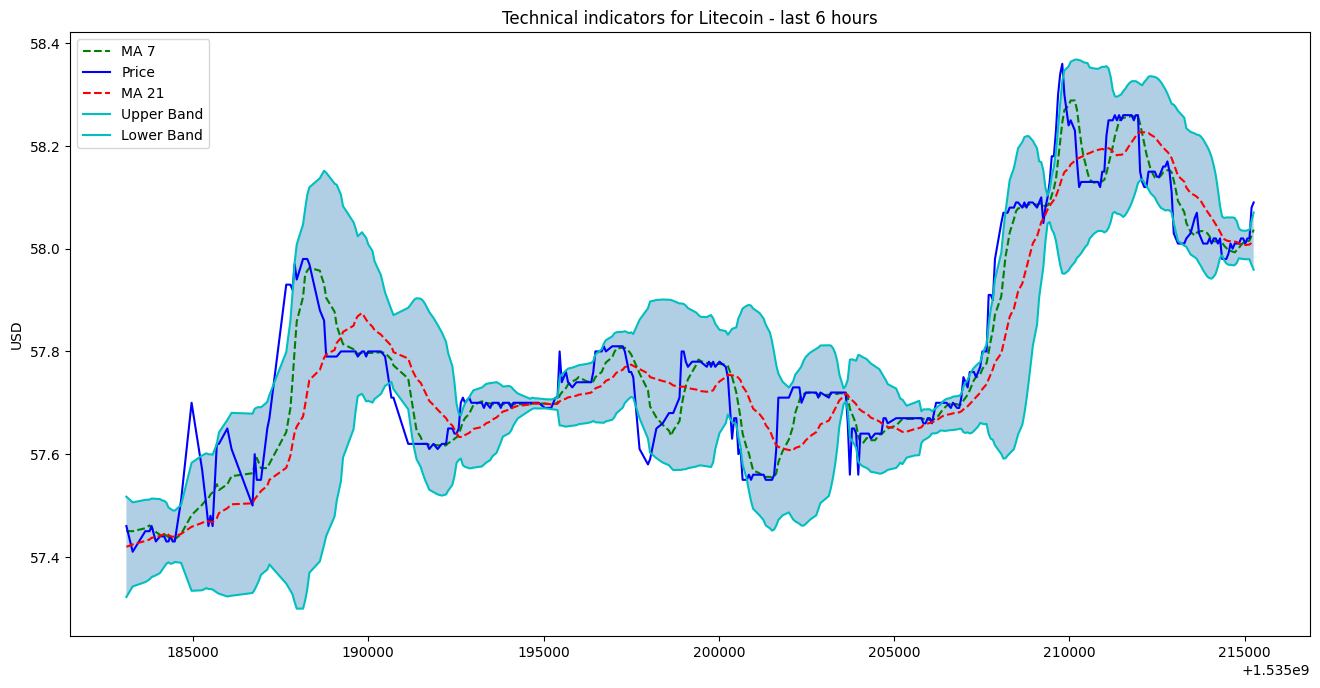

In [90]:
plot_technical_indicators(all4_df, 360)

### Create Label

In [17]:
SEQ_LEQ = 30
FORECAST_PERIOD = 1

In [18]:
def classify(current, future):
    if float(future) > float(current):
        return 1
    else:
        return 0

In [19]:
all4_df['Future'] = all4_df['LTC_close'].shift(-FORECAST_PERIOD)

In [20]:
all4_df['Label'] = list(map(classify, all4_df['LTC_close'], all4_df['Future']))

In [21]:
all4_df.head()

,BCH_close,BCH_volume,BTC_close,BTC_volume,ETH_close,ETH_volume,LTC_close,LTC_volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,Future,Label
time,,,,,,,,,,,,,,,,,,
1528969920,873.650024,1.198600,6486.359863,1.065600,488.00000,101.905365,96.629997,65.206299,96.518570,96.478571,96.487900,96.508591,0.020691,0.075913,96.630396,96.326746,96.599998,0
1528969980,873.859985,1.293300,6487.259766,0.602759,487.98999,303.575714,96.599998,206.481979,96.547141,96.475714,96.498075,96.523019,0.024944,0.078263,96.632239,96.319189,96.639999,1
1528970040,873.750000,7.357900,6487.270020,0.427600,488.00000,20.277039,96.639999,35.712299,96.578570,96.479047,96.510746,96.541411,0.030664,0.086789,96.652626,96.305468,96.660004,1
1528970100,873.309998,2.864491,6490.000000,0.516043,487.98999,20.961819,96.660004,119.928459,96.591427,96.486666,96.523872,96.559993,0.036121,0.093147,96.672961,96.300372,96.660004,0
1528970160,873.309998,0.149200,6490.000000,0.742156,488.00000,19.020500,96.660004,27.055300,96.615714,96.499524,96.535680,96.575619,0.039939,0.100382,96.700287,96.298760,96.660004,0


### Creating Sequences

In [22]:
train_samples = int(all4_df.shape[0] * 0.9)

train_ = all4_df.iloc[:train_samples]
validation_ = all4_df.iloc[train_samples:]

In [23]:
train_.head()

,BCH_close,BCH_volume,BTC_close,BTC_volume,ETH_close,ETH_volume,LTC_close,LTC_volume,ma7,ma21,26ema,12ema,MACD,20sd,upper_band,lower_band,Future,Label
time,,,,,,,,,,,,,,,,,,
1528969920,873.650024,1.198600,6486.359863,1.065600,488.00000,101.905365,96.629997,65.206299,96.518570,96.478571,96.487900,96.508591,0.020691,0.075913,96.630396,96.326746,96.599998,0
1528969980,873.859985,1.293300,6487.259766,0.602759,487.98999,303.575714,96.599998,206.481979,96.547141,96.475714,96.498075,96.523019,0.024944,0.078263,96.632239,96.319189,96.639999,1
1528970040,873.750000,7.357900,6487.270020,0.427600,488.00000,20.277039,96.639999,35.712299,96.578570,96.479047,96.510746,96.541411,0.030664,0.086789,96.652626,96.305468,96.660004,1
1528970100,873.309998,2.864491,6490.000000,0.516043,487.98999,20.961819,96.660004,119.928459,96.591427,96.486666,96.523872,96.559993,0.036121,0.093147,96.672961,96.300372,96.660004,0
1528970160,873.309998,0.149200,6490.000000,0.742156,488.00000,19.020500,96.660004,27.055300,96.615714,96.499524,96.535680,96.575619,0.039939,0.100382,96.700287,96.298760,96.660004,0


In [24]:
import random
from collections import deque
from sklearn import preprocessing

In [25]:
def preprocess(df):

    df = df.drop('Future', 1)

    for col in df.columns: 
        if col != 'Label': 
            df[col] = df[col].pct_change() 
            df.dropna(inplace=True) 
            df[col] = preprocessing.scale(df[col].values)

    df.dropna(inplace=True)

    sequential_data = [] 
    prev_days = deque(maxlen=SEQ_LEQ)

    for i in df.values:
      prev_days.append([n for n in i[:-1]]) 
      if len(prev_days) == SEQ_LEQ: 
        sequential_data.append([np.array(prev_days), i[-1]]) 

    random.shuffle(sequential_data)

    ups = [] 
    downs = []  

    for seq, label in sequential_data: 
        if label == 1:  
            ups.append([seq, label]) 
        elif label == 0:
            downs.append([seq, label]) 

    random.shuffle(downs) 
    random.shuffle(ups)

    lower = min(len(downs), len(ups))

    ups = ups[:lower]  
    downs = downs[:lower]

    sequential_data = ups+downs  

    random.shuffle(sequential_data) 

    return sequential_data

In [26]:
train_sequences = preprocess(train_)
test_sequences = preprocess(validation_)

In [27]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

device = "cuda"

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(0)
torch.manual_seed(0)

### Convert to Tensor

In [30]:
def tensor_converter_e(sequence, label):
  sequence = torch.tensor(sequence).to(device)
  label_tensor = torch.tensor(label).to(device)
  # label_tensor_zero = torch.zeros(1).to(device)

  day_31 = torch.ones((1, 16), dtype=torch.double).to(device)

  new_sequence = torch.cat([sequence, day_31], dim=0)
  # print(new_sequence.shape)

  return new_sequence, label_tensor.long()
  # return new_sequence, label_tensor_zero.long()

In [31]:
train_sequences_tensor = [tensor_converter_e(seq, label) for seq, label in train_sequences]
test_sequences_tensor = [tensor_converter_e(seq, label) for seq, label in test_sequences]

In [ ]:
# from torch.utils.tensorboard import SummaryWriter

# writer = SummaryWriter()

### Transformer Model

In [32]:
import math

class PositionalEncoding(nn.Module):

    def __init__(self, d_model=16, max_len=64):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1).to(device)
        self.register_buffer('pe', pe)
        print(pe.shape)

    def forward(self, x):
        x = x + self.pe[:x.shape[0]]
        return x

In [33]:
class TransEncoder(nn.Module):

  def __init__(self, hparams):
    super(TransEncoder, self).__init__()

    self.pos_encoder = PositionalEncoding()

    self.input_projection = nn.Sequential(
        nn.Linear(hparams.expected_features, hparams.dim_emb//2),
        nn.Tanh(),
        nn.Linear(hparams.dim_emb//2, hparams.dim_emb),
    )
    

    encoder_layers = nn.TransformerEncoderLayer(hparams.dim_emb,
                                                hparams.num_heads,
                                                hparams.dim_feedforward,
                                                hparams.dropout)
    self.transformer_encoder = nn.TransformerEncoder(encoder_layers, hparams.nlayers)

    # self.dropout = nn.Dropout(hparams.dropout)
    self.classifier = nn.Linear(hparams.dim_emb, hparams.num_classes)
    
  def forward(self, src):
    
    T = src.shape[1]
    src = src.transpose(0,1)
    src = self.pos_encoder(src)
    extended_src = self.input_projection(src)
    o = self.transformer_encoder(extended_src, mask=torch.zeros(T, T).float().to(device))
    output = self.classifier(o[-1])

    return output

In [35]:
class HParams():

  expected_features = 16
  num_heads = 4
  dim_feedforward = 32
  dim_emb = 64
  dropout = 0.2
  nlayers = 6
  num_classes = 2

params = HParams()

### Trainer Class

In [36]:
class Trainer():

  def __init__(
    self,
    model: nn.Module,
    loss_function,
    optimizer):

    self.model = model
    self.loss_function = loss_function
    self.optimizer = optimizer

  def train(self, train_dataset, 
            valid_dataset, 
            epochs):

    train_loss = 0.0
    for epoch in range(epochs):
      print(f'Epoch {epoch+1}')

      epoch_loss = 0.0
      self.model.train()

      for step, sentence in enumerate(train_dataset):

        tokens = sentence[0].float()
        labels = sentence[1]

        self.optimizer.zero_grad()

        predictions = self.model(tokens)
        # predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)

        # print(len(predictions[0]))
        # print('***********')
        # print(len(predictions))
        # print('***********')
        # print(len(predictions[0][0]))
        
        temp_loss = self.loss_function(predictions, labels)

        temp_loss.backward()
        self.optimizer.step()

        epoch_loss += temp_loss.tolist()

        
      avg_epoch_loss = epoch_loss / len(train_dataset)
      train_loss += avg_epoch_loss

      print(f'\t[Epoch: {epoch+1}] Training Loss = {avg_epoch_loss}')
      # writer.add_scalar(' Training Loss', avg_epoch_loss, epoch)

      valid_loss = self.evaluate(valid_dataset)
      
      print(f'\t[Epoch: {epoch+1}] Validation Loss = {valid_loss}')
      # writer.add_scalar('Validation Loss', valid_loss, epoch)

    print('Training has finished')
    
    avg_epoch_loss = train_loss / epochs

    return avg_epoch_loss
  

  def evaluate(self, valid_dataset):

    valid_loss = 0.0
    self.model.eval()

    with torch.no_grad():
      for sentence in valid_dataset:
        tokens = sentence[0].float()
        labels = sentence[1]

        predictions = self.model(tokens)
        # predictions = predictions.view(-1, predictions.shape[-1])
        labels = labels.view(-1)

        temp_loss = self.loss_function(predictions, labels)
        valid_loss += temp_loss.tolist()
      
    return valid_loss / len(valid_dataset)

  def predict(self, x):

    self.model.eval()
    
    with torch.no_grad():
        logits = self.model(x)
        predictions = torch.argmax(logits, -1)
        return logits, predictions

### F-Score

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [38]:
def f_score(labels, predictions):
  
  print(f'# instances: {len(labels)}')

  p = precision_score(labels, predictions, average='macro')
  r = recall_score(labels, predictions, average='macro')
  f = f1_score(labels, predictions, average='macro')

  print(f'# precision: {p:.4f}')
  print(f'# recall: {r:.4f}')
  print(f'# f1: {f:.4f}')


### Confusion Matrix

In [39]:
def cm_plot(test_label, pred_labels):

  label=[0, 1]

  cm = confusion_matrix(test_label, pred_labels, label)
  print(cm)

  sum_col_cm = np.sum(cm, axis=1, keepdims=True)
  acc_col_cm = (cm / sum_col_cm.astype(float))

  acc_col_cm = [[round(x, 4) for x in xx] for xx in acc_col_cm]
  acc_df = pd.DataFrame(data=acc_col_cm, index=label, columns=label)

  acc_df.index.name = 'ACTUAL LABELS'
  acc_df.columns.name = 'PREDICTED LABELS'
  fig, ax = plt.subplots(figsize=(8,6))
  sns.heatmap(acc_df, annot=acc_col_cm, annot_kws={"size": 15}, fmt='', ax=ax, cmap="YlGnBu")
  plt.show()

### Prepare Batch Data

In [40]:
train_dataset = DataLoader(train_sequences_tensor, batch_size=64)
valid_dataset = DataLoader(test_sequences_tensor, batch_size=64)

### Transformer Training

In [41]:
model = TransEncoder(params).to(device)
model

torch.Size([64, 1, 16])


TransEncoder(
  (pos_encoder): PositionalEncoding()
  (input_projection): Sequential(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=64, bias=True)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=32, bias=True)
        (dropout): Dropout(p=0.2, inplace=False)
        (linear2): Linear(in_features=32, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.2, inplace=False)
        (dropout2): Dropout(p=0.2, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(

In [43]:
trainer = Trainer(
    model = model,
    loss_function = nn.CrossEntropyLoss(),
    optimizer = optim.Adam(model.parameters(), lr=5e-4),
)

In [44]:
trainer.train(train_dataset, valid_dataset, 20)

Epoch 1
	[Epoch: 1] Training Loss = 0.6932833245328741
	[Epoch: 1] Validation Loss = 0.6877161153391296
Epoch 2
	[Epoch: 2] Training Loss = 0.6845978421330698
	[Epoch: 2] Validation Loss = 0.6813722276220134
Epoch 3
	[Epoch: 3] Training Loss = 0.6815797681023615
	[Epoch: 3] Validation Loss = 0.6804046490613151
Epoch 4
	[Epoch: 4] Training Loss = 0.6795673949131067
	[Epoch: 4] Validation Loss = 0.6788384844275082
Epoch 5
	[Epoch: 5] Training Loss = 0.6779868139983705
	[Epoch: 5] Validation Loss = 0.6766672163617378
Epoch 6
	[Epoch: 6] Training Loss = 0.6763883994479604
	[Epoch: 6] Validation Loss = 0.6789653283708236
Epoch 7
	[Epoch: 7] Training Loss = 0.6751884718118988
	[Epoch: 7] Validation Loss = 0.6771781526359857
Epoch 8
	[Epoch: 8] Training Loss = 0.6757615347456488
	[Epoch: 8] Validation Loss = 0.6806588196286968
Epoch 9
	[Epoch: 9] Training Loss = 0.6749219870962218
	[Epoch: 9] Validation Loss = 0.679875995014228
Epoch 10
	[Epoch: 10] Training Loss = 0.673363990480115
	[Epoch: 

0.6742519813880911

In [60]:
model_save_name = 'tra_head2_layer2_model_drop_epoch20.pth'
path = f"/content/drive/My Drive/DeepLearning/models/{model_save_name}" 
torch.save(model.state_dict(), path)

#### Test

In [45]:
predictions = []
test_labels = []
x = []
for i in range(len(test_sequences_tensor)):

  test_elem = test_sequences_tensor[i]
  test_x, test_y = test_elem[0], test_elem[1]
  x.append(test_x)
  test_labels.append(test_y.tolist())
x = torch.stack(x, dim=0).float()
logits, predictions = trainer.predict(x)
predictions = predictions.cpu()

In [46]:
predictions[:20]

tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0])

In [47]:
model(x)

tensor([[-0.0248, -0.0388],
        [ 0.0276, -0.0282],
        [-0.0445, -0.0185],
        ...,
        [-0.0201, -0.0624],
        [ 0.1177, -0.1827],
        [-0.0082, -0.0532]], device='cuda:0', grad_fn=<AddmmBackward>)

In [48]:
test_labels[:20]

[0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1]

In [49]:
f_score(test_labels, predictions)

# instances: 6494
# precision: 0.6097
# recall: 0.5856
# f1: 0.5616


In [43]:
accuracy_score(test_labels, predictions)

0.5852832512315271

[[1141 2106]
 [ 585 2662]]


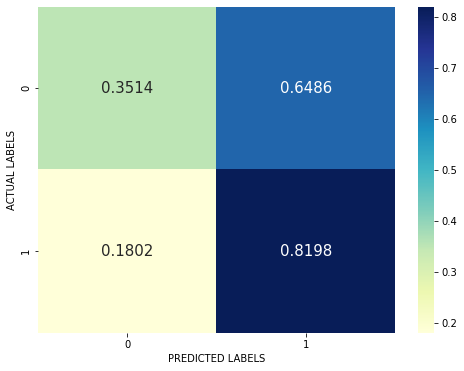

In [50]:
cm_plot(test_labels, predictions) 

In [51]:
# predictions_train_one = []
# train_labels = []


# for i in range(len(train_sequences_tensor)):

#   train_elem = train_sequences_tensor[i]
#   train_x, train_y = train_elem[0], train_elem[1]
      
#   logits, coded_pred = trainer.predict(train_x.unsqueeze(0))
#   predictions_train_one.append(coded_pred[0].tolist()) 
#   train_labels.append(train_y.tolist())

train_predictions = []
train_labels = []
x = []
for i in range(len(train_sequences_tensor)):

  train_elem = train_sequences_tensor[i]
  train_x, train_y = train_elem[0], train_elem[1]
  x.append(train_x)
  train_labels.append(train_y.tolist())
x = torch.stack(x, dim=0).float()
logits, train_predictions = trainer.predict(x)
train_predictions = train_predictions.cpu()

In [52]:
f_score(train_labels, train_predictions)

# instances: 61768
# precision: 0.6121
# recall: 0.5888
# f1: 0.5662


In [ ]:
# accuracy_score(train_labels, predictions_train_one)